In [2]:
import clean_data_svi as cds
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [3]:
svi_df = pd.read_csv("clean_tables/svi_1_tem.csv", index_col="date")
micro_df = pd.read_csv("clean_tables/micro_1.csv", index_col="date")
svi_df.index = pd.to_datetime(svi_df.index, dayfirst=True)
micro_df.index = pd.to_datetime(micro_df.index, dayfirst=True)
#cds.set_datetime_index(svi_df)

In [4]:
svi_df

,SVI,Temperature
date,,
2010-01-01,90.943683,22.030
2010-01-02,84.365325,21.985
2010-01-03,94.541139,21.740
2010-01-04,97.402597,21.815
2010-01-05,107.937686,21.890
...,...,...
2020-09-11,151.869159,31.495
2020-09-12,143.149284,31.260
2020-09-13,143.020595,31.115


<AxesSubplot:xlabel='date'>

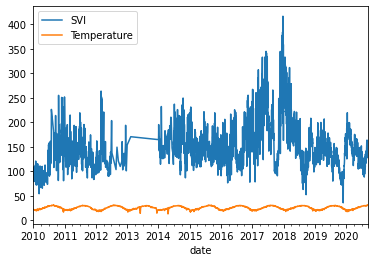

In [5]:
svi_df.plot()

In [10]:
svi_df['SVI'][svi_df['SVI']>180].count()


647

In [7]:
svi_df['SVI'].count()

3911

In [5]:
micro_df

,ameoba_arcella,ameoba_nude ameba,crawling ciliates_aspidisca,crawling ciliates_trachelopylum,free swimming ciliates_lionutus,free swimming ciliates_paramecium,stalked ciliate_epistylis,stalked ciliate_vorticella,stalked ciliate_carchecium,stalked ciliate_tokophyra,...,spirochaetes_spirochaetes,Filaments_Nocardia_index,Filaments_Microthrix_index,Filaments_N. Limicola_index,Filaments_Thiothrix_index,Filaments_0041_0675_index,Filaments_0092_index,Filaments_1851_index,Filaments_beggiatoa_index,Filaments_zoogloea_index
date,,,,,,,,,,,,,,,,,,,,,
2010-02-02,67.0,8.0,NaN,1.0,4.0,NaN,9.0,53.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-08,27.0,8.0,NaN,1.0,9.0,NaN,11.0,38.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-22,5.0,9.0,NaN,0.0,7.0,NaN,2.0,32.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-29,9.0,16.0,NaN,0.0,25.0,NaN,2.0,23.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-01,1.0,8.0,NaN,0.0,8.0,NaN,10.0,10.0,0.0,0.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,9.0,3.0,8.0,0.0,8.0,0.0,9.0,53.0,0.0,0.0,...,1210.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,3.0,1.0
2020-07-28,7.0,29.0,19.0,1.0,10.0,2.0,27.0,70.0,0.0,3.0,...,1183.0,1.0,1.0,4.0,0.0,5.0,0.0,3.0,1.0,1.0
2020-08-03,5.0,5.0,0.0,0.0,13.0,1.0,15.0,32.0,0.0,0.0,...,2200.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,3.0,1.0


In [6]:
join = pd.concat([svi_df, micro_df], axis=1, )

In [7]:
join = join.fillna(method='ffill').dropna(axis=0, how='any')

In [8]:
join

,SVI,Temperature,ameoba_arcella,ameoba_nude ameba,crawling ciliates_aspidisca,crawling ciliates_trachelopylum,free swimming ciliates_lionutus,free swimming ciliates_paramecium,stalked ciliate_epistylis,stalked ciliate_vorticella,...,spirochaetes_spirochaetes,Filaments_Nocardia_index,Filaments_Microthrix_index,Filaments_N. Limicola_index,Filaments_Thiothrix_index,Filaments_0041_0675_index,Filaments_0092_index,Filaments_1851_index,Filaments_beggiatoa_index,Filaments_zoogloea_index
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,221.179625,20.430,5.0,2.0,8.0,1.0,2.0,0.0,4.0,17.0,...,10.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
2018-01-03,233.812950,21.275,5.0,2.0,8.0,1.0,2.0,0.0,4.0,17.0,...,10.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
2018-01-04,239.485981,21.535,5.0,2.0,8.0,1.0,2.0,0.0,4.0,17.0,...,10.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
2018-01-05,307.112069,20.690,5.0,2.0,8.0,1.0,2.0,0.0,4.0,17.0,...,10.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
2018-01-06,287.102473,20.285,5.0,2.0,8.0,1.0,2.0,0.0,4.0,17.0,...,10.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-11,151.869159,31.495,15.0,5.0,15.0,1.0,26.0,4.0,36.0,31.0,...,1197.0,1.0,3.0,5.0,0.0,5.0,0.0,3.0,1.0,2.0
2020-09-12,143.149284,31.260,15.0,5.0,15.0,1.0,26.0,4.0,36.0,31.0,...,1197.0,1.0,3.0,5.0,0.0,5.0,0.0,3.0,1.0,2.0
2020-09-13,143.020595,31.115,15.0,5.0,15.0,1.0,26.0,4.0,36.0,31.0,...,1197.0,1.0,3.0,5.0,0.0,5.0,0.0,3.0,1.0,2.0


In [15]:
len(join)

988

In [16]:
join_arr = join.values

In [93]:
def series_to_supervised(sequences, n_steps_in=1, n_steps_out=1, jump=1, binary=False):
    X, Y = list(), list()

    for i in range(0, len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[out_end_ix - 1:out_end_ix][:, 0]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)


In [127]:
def normalize(X, Y):
    scalers = list()
    for i in tqdm(range(X.shape[1])):
        scalers.append(MinMaxScaler())
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :])

    scalers.append(MinMaxScaler())
    Y = scalers[i + 1].fit_transform(Y)
    return X, Y, scalers

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 332.99it/s]


Train on 740 samples
Epoch 1/30
740/740 [==============================] - 3s 4ms/sample - loss: 2.1584 - accuracy: 0.0014
Epoch 2/30
740/740 [==============================] - 0s 407us/sample - loss: 1.3965 - accuracy: 0.0014
Epoch 3/30
740/740 [==============================] - 0s 395us/sample - loss: 1.1171 - accuracy: 0.0014
Epoch 4/30
740/740 [==============================] - 0s 408us/sample - loss: 0.9929 - accuracy: 0.0014
Epoch 5/30
740/740 [==============================] - 0s 391us/sample - loss: 0.9208 - accuracy: 0.0014
Epoch 6/30
740/740 [==============================] - 0s 418us/sample - loss: 0.8580 - accuracy: 0.0014
Epoch 7/30
740/740 [==============================] - 0s 392us/sample - loss: 0.8046 - accuracy: 0.0014
Epoch 8/30
740/740 [==============================] - 0s 418us/sample - loss: 0.7639 - accuracy: 0.0014
Epoch 9/30
740/740 [==============================] - 0s 400us/sample - loss: 0.7351 - accuracy: 0.0014
Epoch 10/30
740/740 [========================

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 499.38it/s]


Train on 739 samples
Epoch 1/30
739/739 [==============================] - 3s 5ms/sample - loss: 0.8769 - accuracy: 0.0000e+00
Epoch 2/30
739/739 [==============================] - 0s 589us/sample - loss: 0.7206 - accuracy: 0.0000e+00
Epoch 3/30
739/739 [==============================] - 0s 576us/sample - loss: 0.6903 - accuracy: 0.0000e+00
Epoch 4/30
739/739 [==============================] - 0s 574us/sample - loss: 0.6802 - accuracy: 0.0000e+00
Epoch 5/30
739/739 [==============================] - 0s 571us/sample - loss: 0.6735 - accuracy: 0.0000e+00
Epoch 6/30
739/739 [==============================] - 0s 590us/sample - loss: 0.6675 - accuracy: 0.0000e+00
Epoch 7/30
739/739 [==============================] - 0s 596us/sample - loss: 0.6621 - accuracy: 0.0000e+00
Epoch 8/30
739/739 [==============================] - 0s 635us/sample - loss: 0.6571 - accuracy: 0.0000e+00
Epoch 9/30
739/739 [==============================] - 0s 613us/sample - loss: 0.6522 - accuracy: 0.0000e+00
Epoch 10/

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 499.58it/s]


Train on 738 samples
Epoch 1/30
738/738 [==============================] - 4s 6ms/sample - loss: 0.8973 - accuracy: 0.0014
Epoch 2/30
738/738 [==============================] - 1s 753us/sample - loss: 0.7437 - accuracy: 0.0014
Epoch 3/30
738/738 [==============================] - 1s 678us/sample - loss: 0.7107 - accuracy: 0.0014
Epoch 4/30
738/738 [==============================] - 1s 835us/sample - loss: 0.6982 - accuracy: 0.0014
Epoch 5/30
738/738 [==============================] - 1s 717us/sample - loss: 0.6894 - accuracy: 0.0014
Epoch 6/30
738/738 [==============================] - 1s 716us/sample - loss: 0.6810 - accuracy: 0.0014
Epoch 7/30
738/738 [==============================] - 1s 778us/sample - loss: 0.6732 - accuracy: 0.0014
Epoch 8/30
738/738 [==============================] - 1s 811us/sample - loss: 0.6654 - accuracy: 0.0014
Epoch 9/30
738/738 [==============================] - 1s 739us/sample - loss: 0.6574 - accuracy: 0.0014
Epoch 10/30
738/738 [========================

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 570.94it/s]


Train on 738 samples
Epoch 1/30
738/738 [==============================] - 4s 5ms/sample - loss: 1.2245 - accuracy: 0.0014
Epoch 2/30
738/738 [==============================] - 1s 827us/sample - loss: 0.7364 - accuracy: 0.0014
Epoch 3/30
738/738 [==============================] - 1s 953us/sample - loss: 0.6985 - accuracy: 0.0014
Epoch 4/30
738/738 [==============================] - 1s 879us/sample - loss: 0.6843 - accuracy: 0.0014
Epoch 5/30
738/738 [==============================] - 1s 934us/sample - loss: 0.6743 - accuracy: 0.0014
Epoch 6/30
738/738 [==============================] - 1s 871us/sample - loss: 0.6650 - accuracy: 0.0014
Epoch 7/30
738/738 [==============================] - 1s 875us/sample - loss: 0.6578 - accuracy: 0.0014
Epoch 8/30
738/738 [==============================] - 1s 982us/sample - loss: 0.6513 - accuracy: 0.0027
Epoch 9/30
738/738 [==============================] - 1s 911us/sample - loss: 0.6463 - accuracy: 0.0027
Epoch 10/30
738/738 [========================

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 624.47it/s]


Train on 737 samples
Epoch 1/30
737/737 [==============================] - 6s 8ms/sample - loss: 2.7044 - accuracy: 0.0014
Epoch 2/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.8782 - accuracy: 0.0014
Epoch 3/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.7739 - accuracy: 0.0014
Epoch 4/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.7270 - accuracy: 0.0014
Epoch 5/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.6911 - accuracy: 0.0014
Epoch 6/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.6735 - accuracy: 0.0014
Epoch 7/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.6659 - accuracy: 0.0014
Epoch 8/30
737/737 [==============================] - 1s 1ms/sample - loss: 0.6597 - accuracy: 0.0014
Epoch 9/30
737/737 [==============================] - 1s 999us/sample - loss: 0.6548 - accuracy: 0.0014
Epoch 10/30
737/737 [==============================] - 1s 1

100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 499.58it/s]


Train on 736 samples
Epoch 1/30
736/736 [==============================] - 4s 5ms/sample - loss: 2.2514 - accuracy: 0.0014
Epoch 2/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.8552 - accuracy: 0.0014
Epoch 3/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.7663 - accuracy: 0.0014
Epoch 4/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.7240 - accuracy: 0.0014
Epoch 5/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.6987 - accuracy: 0.0014
Epoch 6/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.6858 - accuracy: 0.0014
Epoch 7/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.6740 - accuracy: 0.0014
Epoch 8/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.6655 - accuracy: 0.0014
Epoch 9/30
736/736 [==============================] - 1s 1ms/sample - loss: 0.6574 - accuracy: 0.0027
Epoch 10/30
736/736 [==============================] - 1s 1ms

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 581.88it/s]


Train on 735 samples
Epoch 1/30
735/735 [==============================] - 4s 5ms/sample - loss: 1.3822 - accuracy: 0.0000e+00
Epoch 2/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.8653 - accuracy: 0.0000e+00
Epoch 3/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.7408 - accuracy: 0.0000e+00
Epoch 4/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.7050 - accuracy: 0.0000e+00
Epoch 5/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6881 - accuracy: 0.0000e+00
Epoch 6/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6720 - accuracy: 0.0014
Epoch 7/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6595 - accuracy: 0.0014
Epoch 8/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6507 - accuracy: 0.0014
Epoch 9/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6462 - accuracy: 0.0014
Epoch 10/30
735/735 [====================

100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 727.75it/s]


Train on 735 samples
Epoch 1/30
735/735 [==============================] - 4s 5ms/sample - loss: 0.8412 - accuracy: 0.0000e+00
Epoch 2/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6760 - accuracy: 0.0000e+00
Epoch 3/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6571 - accuracy: 0.0014
Epoch 4/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6459 - accuracy: 0.0014
Epoch 5/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6385 - accuracy: 0.0014
Epoch 6/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6355 - accuracy: 0.0014
Epoch 7/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6340 - accuracy: 0.0014
Epoch 8/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6320 - accuracy: 0.0014
Epoch 9/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6312 - accuracy: 0.0014
Epoch 10/30
735/735 [==============================] 

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 642.43it/s]


Train on 734 samples
Epoch 1/30
734/734 [==============================] - 4s 5ms/sample - loss: 1.6862 - accuracy: 0.0014
Epoch 2/30
734/734 [==============================] - 1s 1ms/sample - loss: 0.7253 - accuracy: 0.0014TA: 0s - loss: 0
Epoch 3/30
734/734 [==============================] - 1s 1ms/sample - loss: 0.6985 - accuracy: 0.0014
Epoch 4/30
734/734 [==============================] - 1s 2ms/sample - loss: 0.6845 - accuracy: 0.0014
Epoch 5/30
734/734 [==============================] - 1s 1ms/sample - loss: 0.6726 - accuracy: 0.0014
Epoch 6/30
734/734 [==============================] - 1s 1ms/sample - loss: 0.6637 - accuracy: 0.0014
Epoch 7/30
734/734 [==============================] - 1s 2ms/sample - loss: 0.6548 - accuracy: 0.00140s - loss: 0.6556 - 
Epoch 8/30
734/734 [==============================] - 1s 2ms/sample - loss: 0.6489 - accuracy: 0.0027
Epoch 9/30
734/734 [==============================] - 1s 2ms/sample - loss: 0.6443 - accuracy: 0.0027
Epoch 10/30
734/734 [====

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 475.87it/s]


Train on 733 samples
Epoch 1/30
733/733 [==============================] - 6s 8ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 2/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 3/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 4/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 5/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 6/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 7/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 8/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 9/30
733/733 [==============================] - 1s 2ms/sample - loss: 5.6951 - accuracy: 0.0014
Epoch 10/30
733/733 [==============================] - 1s 2ms

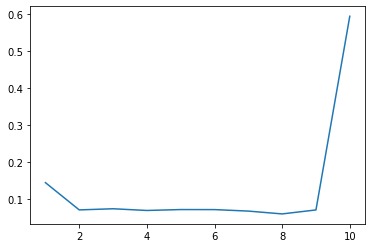

In [141]:
rmse_list=[]
for i in range (1,11):
    X, Y = series_to_supervised(join_arr, n_steps_in=i)
    X_normalize, Y_normalize, scalers = normalize(X, Y)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.25, random_state=42)
    model = Sequential()
    model.add(LSTM(units=100, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)
    Yhat = model.predict(Xtest)
    rmse = sqrt(mean_squared_error(ytest, Yhat))
    rmse_list.append(rmse)
x=range(1,11)
plt.plot(x,rmse_list)

In [131]:
#model = Sequential([
#    Dense(units=16, input_shape=(Xtrain.shape[1], 1), activation='relu'),
#    Dense(units=32, activation='relu')
#])

In [135]:
#Xtrain[:,0,:]

In [136]:
#pd.DataFrame(Xtrain[:,0,:]).to_csv(pathlib.Path("clean_tables/Xtrain.csv"))

model

In [143]:
def evaluate(model, Xtest, Ytest, scalers, binary=False):
    Yhat = model.predict(Xtest)
    if not binary:
        Yhat = scalers[-1].inverse_transform(Yhat)
        Ytest = scalers[-1].inverse_transform(Ytest)
    return Yhat, Ytest

In [146]:
X, Y = series_to_supervised(join_arr, n_steps_in=8)
X_normalize, Y_normalize, scalers = normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.25, random_state=42)
model = Sequential()
model.add(LSTM(units=100, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1, activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 499.57it/s]


Train on 735 samples
Epoch 1/30
735/735 [==============================] - 5s 6ms/sample - loss: 0.9397 - accuracy: 0.0000e+00
Epoch 2/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6995 - accuracy: 0.0000e+00
Epoch 3/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6779 - accuracy: 0.0000e+00
Epoch 4/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6667 - accuracy: 0.0000e+000s - loss: 0.6730 - accuracy
Epoch 5/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6567 - accuracy: 0.0000e+000s - loss: 0.6
Epoch 6/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6488 - accuracy: 0.0014
Epoch 7/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6438 - accuracy: 0.0014
Epoch 8/30
735/735 [==============================] - 1s 1ms/sample - loss: 0.6410 - accuracy: 0.0014
Epoch 9/30
735/735 [==============================] - 1s 2ms/sample - loss: 0.6392 - accuracy: 0.0014

In [200]:
X.shape

(980, 8, 29)

In [168]:
Yhat, Ytest = evaluate(model, Xtest, ytest, scalers)

In [193]:
df=pd.DataFrame(Ytest[:,0])

In [194]:
df.columns=["Yreal"]

In [195]:
df

,Yreal
0,154.929577
1,161.830357
2,191.082802
3,94.026549
4,153.399668
...,...
240,104.166667
241,126.728111
242,140.134529
243,147.368421


In [196]:
df['Ypredict']=pd.DataFrame(Yhat[:,0])

In [197]:
df

,Yreal,Ypredict
0,154.929577,147.126038
1,161.830357,166.505493
2,191.082802,160.217712
3,94.026549,108.641167
4,153.399668,193.032761
...,...,...
240,104.166667,111.187805
241,126.728111,131.460373
242,140.134529,144.461639
243,147.368421,151.877014


<AxesSubplot:>

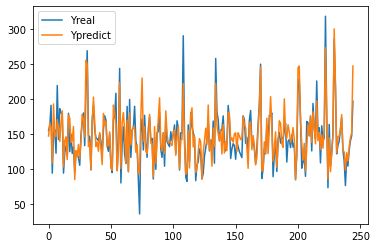

In [198]:
df.plot()

In [ ]:
for i in range(Y_normalize.shape[1]):
    #reverse the data from 0,1 to the real numbers
    z = scalers[i + 1].inverse_transform(Y_normalize)